### Single node

In [20]:

import sys
import os
sys.path.insert(0, os.path.abspath("/home/hajta2/study/sonar-FWI/cli"))
from simulation.sonar import Sonar
from simulation.utils import CircleBottom, EllipsisBottom, run_beam, run_beam_MPI
from simulation.sources import GaborSource
from simulation.plotting import plot_velocity

import matplotlib.pyplot as plt
import numpy as np
from devito import configuration
configuration["log-level"] = "ERROR"
plt.rcParams["figure.figsize"] = (5, 5)
sys.stderr = open(os.devnull, "w")

In [21]:
domain_size = (6, 3)
radius = 2.8
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50

In [22]:
sonar = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, cy, radius), source_distance=source_distance, ns=ns)
sonar.set_source()
sonar.finalize(snapshot_delay=0.1)

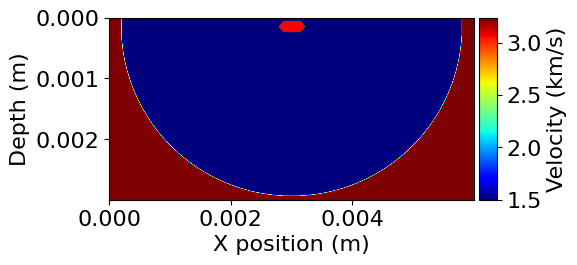

In [23]:
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

### MPI

In [2]:
import ipyparallel as ipp
from mpi4py import MPI
c = ipp.Client(profile='mpi')

In [3]:
%%px --no-stream --group-outputs=engine
import sys
import os
sys.path.insert(0, os.path.abspath("/home/hajta2/study/sonar-FWI/cli"))
from simulation.sonar import Sonar
from simulation.utils import CircleBottom, EllipsisBottom, run_beam, run_beam_MPI, positions_line
from simulation.sources import GaborSource
from simulation.plotting import plot_velocity

from examples.seismic import Receiver

import matplotlib.pyplot as plt
import numpy as np

from devito import configuration
configuration['mpi'] = True
configuration['language'] = 'openmp'

%px: 100%|██████████| 4/4 [00:00<00:00, 10.47tasks/s]


In [4]:
%%px

domain_size = (6, 3)
radius = 2.8
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance
f0 = 50
spatial_dist = round(v_env / f0 / 3, 3) / 2
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [9]:
%%px --no-stream --group-outputs=engine

from simulation.utils import gen_velocity_profile

if rank == 0:
    vp = gen_velocity_profile(EllipsisBottom(True), domain_dims, spatial_dist, v_water=v_env)
else:
    vp = None
vp = comm.bcast(vp, root=0)

[stderr:0] 
51it [00:00, 168.20it/s]


In [10]:
%%px --no-stream --group-outputs=engine

sonar = Sonar(domain_size, f0, v_env, vp, source_distance=source_distance, ns=ns, spatial_dist=spatial_dist)
sonar.set_source()
sonar.finalize()

%px: 100%|██████████| 4/4 [00:02<00:00,  1.43tasks/s]


[stderr:0] 
Operator `initdamp` ran in 0.18 s
[stderr:1] 
Operator `initdamp` ran in 0.18 s
[stderr:2] 
Operator `initdamp` ran in 0.18 s
[stderr:3] 
Operator `initdamp` ran in 0.18 s


In [11]:
%%px
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

%px:   0%|          | 0/4 [00:07<?, ?tasks/s]


Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [34]:
%%px
print(sonar.src.data)

[stdout:1] [[ 3.7266532e-06  3.7266532e-06  3.7266532e-06 ...  3.7266532e-06
   3.7266532e-06  3.7266532e-06]
 [ 3.9544639e-06  3.9544639e-06  3.9544639e-06 ...  3.9544639e-06
   3.9544639e-06  3.9544639e-06]
 [ 4.1695580e-06  4.1695580e-06  4.1695580e-06 ...  4.1695580e-06
   4.1695580e-06  4.1695580e-06]
 ...
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


[stdout:3] [[ 3.7266532e-06  3.7266532e-06  3.7266532e-06 ...  3.7266532e-06
   3.7266532e-06  3.7266532e-06]
 [ 3.9544639e-06  3.9544639e-06  3.9544639e-06 ...  3.9544639e-06
   3.9544639e-06  3.9544639e-06]
 [ 4.1695580e-06  4.1695580e-06  4.1695580e-06 ...  4.1695580e-06
   4.1695580e-06  4.1695580e-06]
 ...
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


[stdout:0] [[ 3.7266532e-06  3.7266532e-06  3.7266532e-06 ...  3.7266532e-06
   3.7266532e-06  3.7266532e-06]
 [ 3.9544639e-06  3.9544639e-06  3.9544639e-06 ...  3.9544639e-06
   3.9544639e-06  3.9544639e-06]
 [ 4.1695580e-06  4.1695580e-06  4.1695580e-06 ...  4.1695580e-06
   4.1695580e-06  4.1695580e-06]
 ...
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


[stdout:2] [[ 3.7266532e-06  3.7266532e-06  3.7266532e-06 ...  3.7266532e-06
   3.7266532e-06  3.7266532e-06]
 [ 3.9544639e-06  3.9544639e-06  3.9544639e-06 ...  3.9544639e-06
   3.9544639e-06  3.9544639e-06]
 [ 4.1695580e-06  4.1695580e-06  4.1695580e-06 ...  4.1695580e-06
   4.1695580e-06  4.1695580e-06]
 ...
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


In [17]:
%%px --no-stream --group-outputs=engine

gathered_src_data = None
if rank == 0:
    gathered_src_data = np.zeros((sonar.src.data.shape[0], ns), dtype=np.float32)
    
comm.Gather(sonar.src.data, gathered_src_data, root=0)

In [37]:
%%px
plt.plot(sonar.src.data)
plt.show()

%px:  75%|███████▌  | 3/4 [00:28<00:09,  9.53s/tasks]


In [18]:
%%px --no-stream --group-outputs=engine

if rank == 0:
    with open('/home/hajta2/study/sonar-FWI/notebooks/output/mpi_src_data.npy', 'wb') as f:
        np.save(f, gathered_src_data)

### Compare src

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mpi_src = np.load('/home/hajta2/study/sonar-FWI/notebooks/output/mpi_src_data.npy')

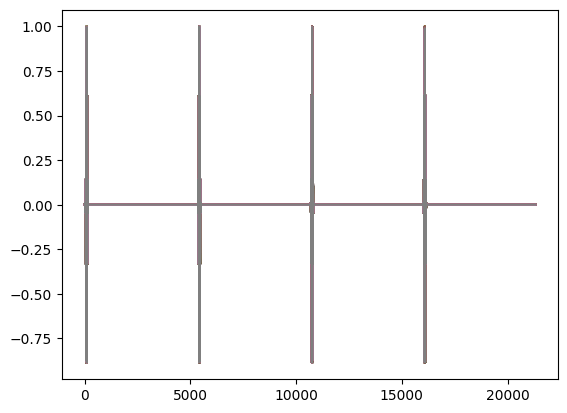

In [5]:
plt.plot(mpi_src)